In this notebook, we will skip the training part and start examining how the trained model works in order to get to its predictions. In the following notebooks we will see how the model was trained.

In [1]:
%matplotlib inline    
#displays images in the notebook rather than a separate window
from scipy.misc import imread, imresize #reading and resizing images
import matplotlib.pyplot as plt #displaying images
import dask.bag as db  #For easy parallelizatoin of applying a function on a list
import pandas as pd
import glob #getting the list of files in a directory
import numpy as np
import pickle #use pickle for serializing Python objects to disk
from keras.models import load_model
import keras.backend as K

Using TensorFlow backend.


## Loading pretrained model and displaying its summary

In [2]:
model = load_model('driver_model_trained_50_epochs.h5')

C:\Anaconda3\lib\site-packages\keras\models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
#how to understand layers 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
__________

## Model Evaluation

In [27]:
((X_train, y_train), (X_test, y_test)) =  pickle.load(open('driver_images_processed.pckl', 'rb'))

In [28]:
# ?????why .255.0
y_test_hat = model.predict(X_test/255.0)

In [29]:
y_test_hat.shape

(1035, 2)

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_curve = roc_curve(y_test, y_test_hat[:,1])
print("ROC-AUC score: {}".format(roc_auc_score(y_test, y_test_hat[:,1])))

ROC-AUC score: 0.9836737747848859


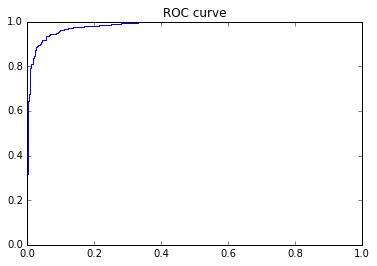

In [31]:
plt.plot(roc_curve[0], roc_curve[1])
plt.title('ROC curve')

## Running inference on two sample drivers

In [32]:
#########???????????????????????????????????
#what is 280, 255, 280is random imigage number 
sample_driving = X_test[0,:,:,0]/255  # Normalizing to 0-1 range
sample_texting = X_test[280,:,:,0]/255

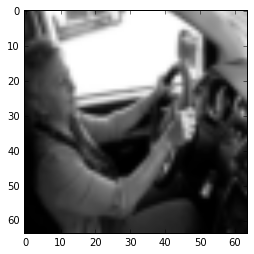

In [33]:
plt.imshow(sample_driving, cmap='gray')

Model gives 0.99 probability for this driver to be in the class *normal driving*:

In [34]:
# np.newaxis: use adding two more demintions, creating dummy axis 
model.predict(sample_driving[np.newaxis, :, :, np.newaxis])

array([[  9.99998450e-01,   1.51544145e-06]], dtype=float32)

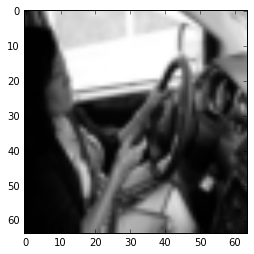

In [35]:
plt.imshow(sample_texting, cmap='gray')

Model gives 0.99 probability for this driver to be in the class *texting*:

In [36]:
model.predict(sample_texting[np.newaxis, :, :, np.newaxis])

array([[  1.43141748e-04,   9.99856830e-01]], dtype=float32)

## Layer by layer examination
### First convolution ?????????

In [37]:
#K.function tensor flow backend ; get intermediate output from lineage graph 
f_layer1 = K.function([model.layers[0].input], [model.layers[0].output])
out1 = f_layer1([sample_driving[np.newaxis, :, :, np.newaxis]])[0]

In [38]:
########################
model.layers[0].get_weights()[0][:,:,0,0].reshape((3,3))

array([[-0.06422413,  0.04520325,  0.10206079],
       [ 0.05393066,  0.11026428, -0.02441456],
       [ 0.07233685, -0.12040798, -0.10271556]], dtype=float32)

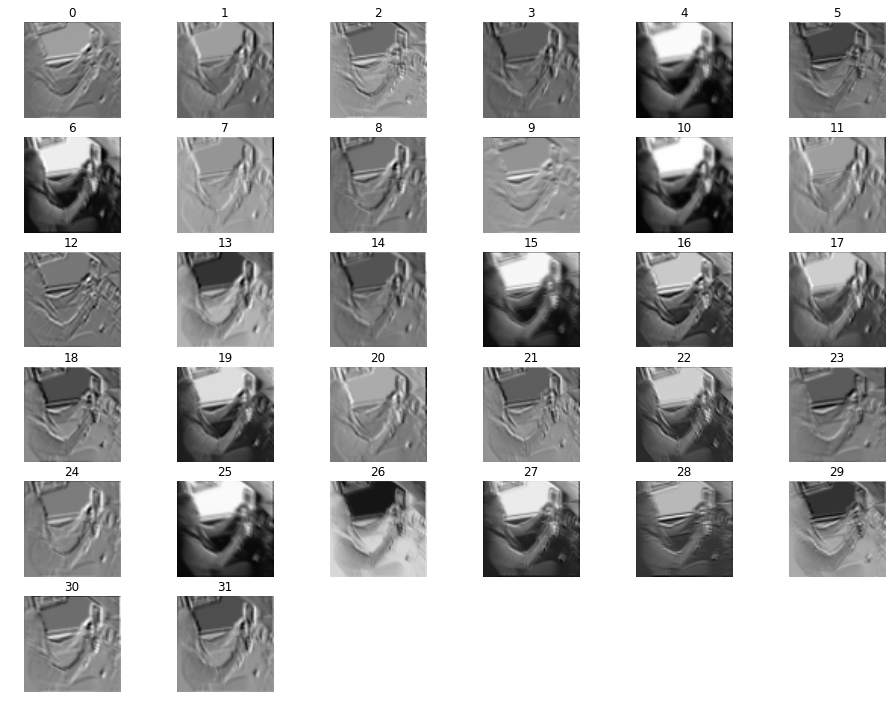

In [39]:
plt.figure(figsize=(16, 12))
for i in range(32):
    # 6 image by image display 
    plt.subplot(6,6, i+1)
    plt.imshow(out1[0, :, :, i], cmap='gray')
    plt.title(str(i))
    plt.axis('off')

### Activation (rectifier function)
This function has commonly replaced the sigmoid function in neural networks. It has demonstrated better training performance, alleviated the vanishing and exploding gradients problem with the sigmoid function. 

[-1, 1, -1, 1]

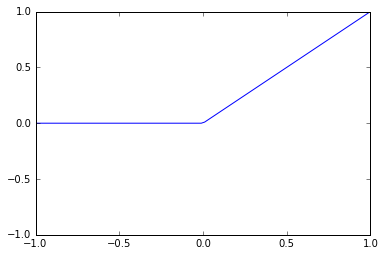

In [40]:
t = np.linspace(-1, 1, 100)
y = t.copy()
y[t<0] = 0
plt.plot(t,y)
plt.axis([-1,1, -1, 1])

In [41]:
f_layer2 = K.function([model.layers[0].input], [model.layers[1].output])
out2 = f_layer2([sample_driving[np.newaxis, :, :, np.newaxis]])[0]

In [42]:
out2.shape

(1, 64, 64, 32)

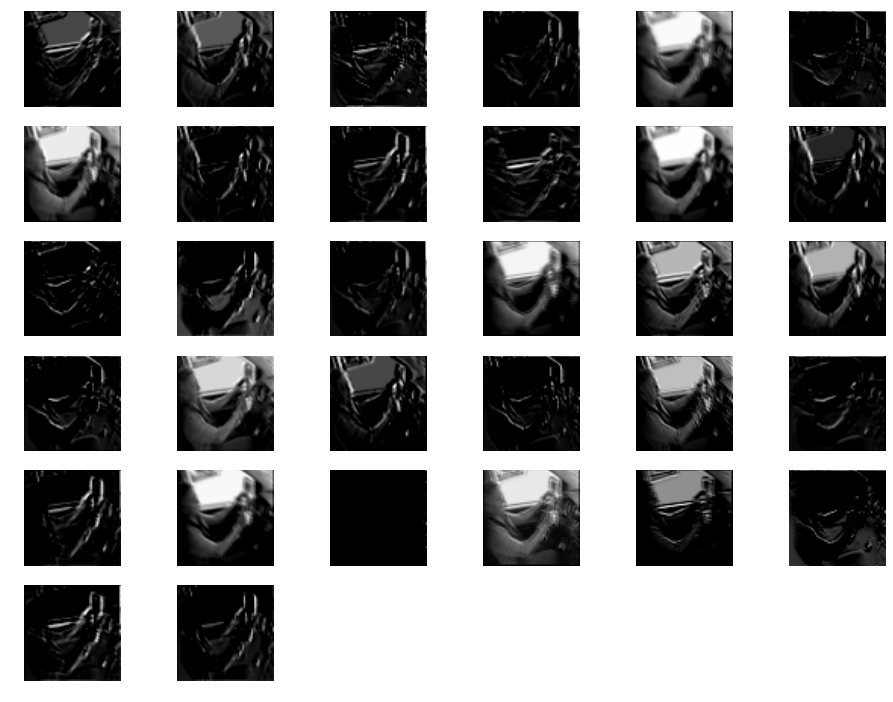

In [43]:
plt.figure(figsize=(16, 12))
for i in range(32):
    plt.subplot(6,6, i+1)
    plt.imshow(out2[0, :, :, i], cmap='gray')
    plt.axis('off')

### Max pooling (downsampling)

In [44]:
f_layer3 = K.function([model.layers[0].input], [model.layers[2].output])
out3 = f_layer3([sample_driving[np.newaxis, :, :, np.newaxis]])[0]

In [45]:
out3.shape

(1, 32, 32, 32)

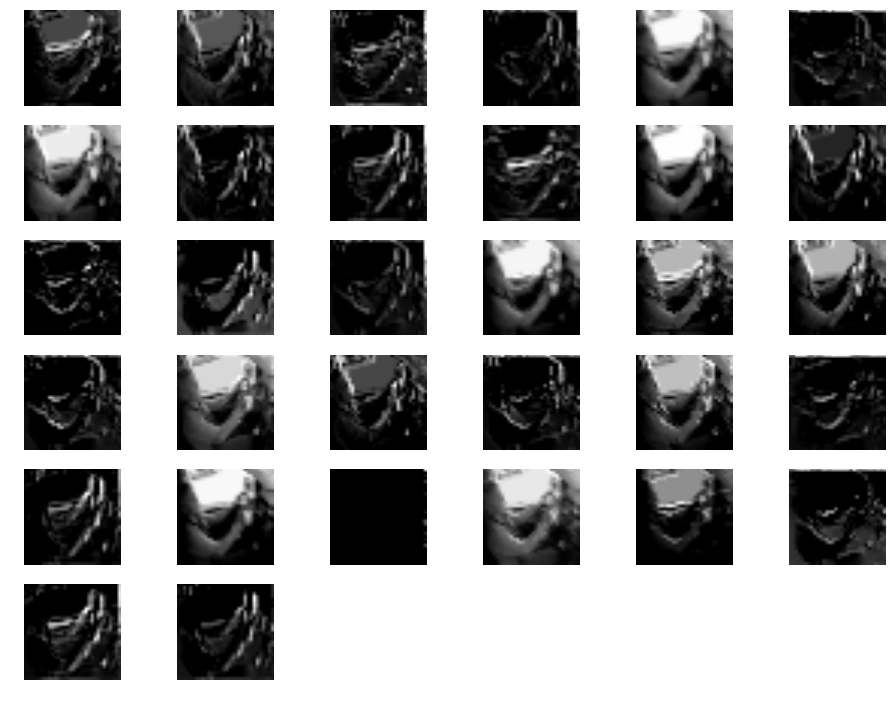

In [46]:
plt.figure(figsize=(16, 12))
for i in range(32):
    plt.subplot(6,6, i+1)
    plt.imshow(out3[0, :, :, i], cmap='gray')
    plt.axis('off')

### Dropout
Dropout is a regularization technique that helps reduce overfitting. It consists of randomly turning off some pixel values during training. For details, see http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

In [47]:
f_layer4 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[3].output])
out4 = f_layer4([sample_driving[np.newaxis, :, :, np.newaxis], 1])[0]

In [48]:
out4.shape

(1, 32, 32, 32)

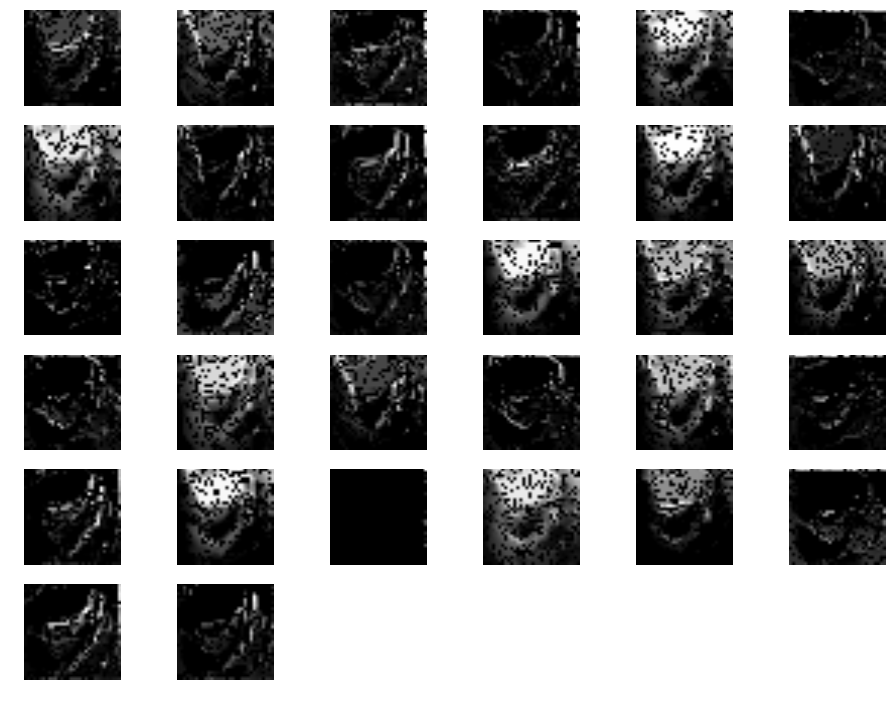

In [49]:
plt.figure(figsize=(16, 12))
for i in range(32):
    plt.subplot(6,6, i+1)
    plt.imshow(out4[0, :, :, i], cmap='gray')
    plt.axis('off')

### Last image layer

In [50]:
f_layer15 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[14].output])
out15 = f_layer15([sample_driving[np.newaxis, :, :, np.newaxis], 0])[0]

In [51]:
out15.shape

(1, 6, 6, 6)

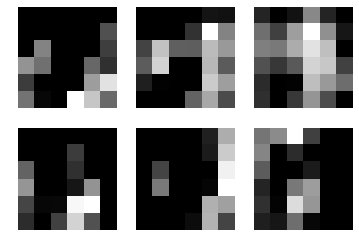

In [52]:
plt.figure(figsize=(6, 4))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(out15[0, :, :, i], cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.axis('tight')

### Flattening : one image becomes one row

In [53]:
f_layer17 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[16].output])

out17 = f_layer17([sample_driving[np.newaxis, :, :, np.newaxis], 0])[0]

In [54]:
out17.shape

(1, 512)

<Container object of 3 artists>

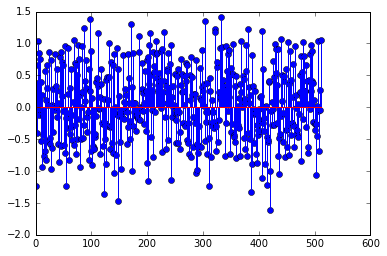

In [55]:
plt.stem(out17[0,:])